# Exploring Word Vectors 


In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# All the dependencies you need, can be installed by running .
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
%matplotlib inline

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /Users/gbonco/nltk_data...


## Word embeddings

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, we will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *word2vec*. 



**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

##  Count-Based Word Vectors

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | START | all | that | glitters | is   | not  | gold  | well | ends | END |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| START    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| END      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add START and END tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine START and END tokens encapsulating each document, e.g., "START All that glitters is not gold END", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 



### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus.  The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. 

In [3]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [4]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

###  `distinct_words` 



In [5]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    
   
    
    # ------------------
    corpus_words = sorted(list(set([word for words_list in corpus for word in words_list])))
    num_corpus_words = len(corpus_words)
        
    # ------------------

    return corpus_words, num_corpus_words

###  `compute_co_occurrence_matrix` 

In [12]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # ------------------
    M = np.zeros((num_words, num_words))
    word2Ind = dict(zip(words, range(num_words)))
    
    for doc in corpus:
        current_idx = 0
        doc_len = len(doc)
        while current_idx < doc_len:
            left_boudary = max(current_idx-window_size, 0)
            right_boundary = min(current_idx+window_size+1, doc_len)
            outside_words = doc[left_boudary:current_idx] + doc[current_idx+1:right_boundary]
            center_word = doc[current_idx]
            center_idx = word2Ind[center_word]
            
            for outside_word in outside_words:
                outside_idx = word2Ind[outside_word]
                M[outside_idx, center_idx] += 1
            
            current_idx += 1
    # ------------------
    return M, word2Ind

###  `reduce_to_k_dim` 



In [10]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------

    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    
    # ------------------
    
    print("Done.")
    return M_reduced

###  `plot_embeddings` 

function to plot a set of 2D vectors in 2D space. 

In [13]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    x_coords = M_reduced[:, 0]
    y_coords = M_reduced[:, 1]
    
    for word in words:
        idx = word2Ind[word]
        embedding = M_reduced[idx]
        x = embedding[0]
        y = embedding[1]
        
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)

    # ------------------

### Co-Occurrence Plot Analysis 

We will compute the co-occurrence matrix with fixed window of 4, over the Reuters "crude" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). 
**Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


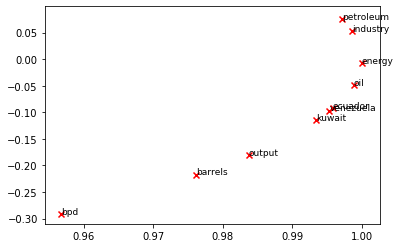

In [16]:
# -----------------------------
# Run This Cell to Produce Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

We can see there are some clusters such as:  
- bdp
- barrels
- oil
- kuwait, venezuela, ecuador
- barrels, bpd, ecuador, energy, industry, output, petroleum


##  Prediction-Based Word Vectors 

We shall explore the embeddings produced by word2vec. [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).



In [17]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [18]:
# -----------------------------------
# Run Cell to Load Word Vectors
# -----------------------------------
wv_from_bin = load_word2vec()

[=================================================-] 99.7% 1658.6/1662.8MB downloaded
Loaded vocab size 3000000


### Reducing dimensionality of Word2Vec Word Embeddings
Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

1. Put the 3 million word2vec vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 300-dimensional to 2-dimensional.

In [19]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [20]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


### Word2Vec Plot Analysis 

Plot the 2D word2vec embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.



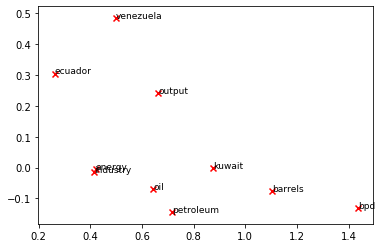

In [21]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

 According to distance, there are two clusters:
- energy, industry
- oil, petroleum

This word embeddings are more separated when compare to co-occurence word embeddings

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective L1 and L2 Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Polysemous Words (2 points) [code + written] 
Let's find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". 

In [26]:
# ------------------
# Write your polysemous word exploration code here.

wv_from_bin.most_similar("once")

# ------------------

[('again', 0.6522716879844666),
 ('Once', 0.6069896221160889),
 ('then', 0.6024325489997864),
 ('never', 0.6013646125793457),
 ('when', 0.596433162689209),
 ('finally', 0.5260250568389893),
 ('twice', 0.5185743570327759),
 ('eventually', 0.5088154077529907),
 ('if', 0.5039767622947693),
 ('suddenly', 0.4684067964553833)]

'once' has two meanings: 
- *again*, *twice*
- *when* , *if*

Many polysemous words have top 10 most similarity (cosine) words that didn't contain two meanings because of:
- Some words in top 10 don't have the same meaning with query word. Sometimes they even have *opposite meaning* , e.g : 'boy' & 'girl', but word embedding treats them the same because their co-occurence are the same
- Some words in top 10 are another form ( upper case, adj, verb, noun ...) of query word

###  Synonyms & Antonyms 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 



In [28]:
# ------------------
# Write your synonym & antonym exploration code here.

w1 = "men"
w2 = "gentlemen"
w3 = "women"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

# ------------------

Synonyms men, gentlemen have cosine distance: 0.6292952299118042
Antonyms men, women have cosine distance: 0.23250627517700195


- Some words that are antonyms, but they are usually used in the same context, so their distance is lower than the synonyms
- Even where two words do seem to have more or less identical meanings, they will often be used in different contexts

### Solving Analogies with Word Vectors
Word2Vec vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x", what is x?



In [29]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]


In [32]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'doctor'], negative=['man']))

[('gynecologist', 0.7093892097473145),
 ('nurse', 0.647728681564331),
 ('doctors', 0.6471461057662964),
 ('physician', 0.64389967918396),
 ('pediatrician', 0.6249487996101379),
 ('nurse_practitioner', 0.6218314170837402),
 ('obstetrician', 0.6072014570236206),
 ('ob_gyn', 0.5986712574958801),
 ('midwife', 0.5927063226699829),
 ('dermatologist', 0.5739566087722778)]


###  Incorrect Analogy 


In [33]:
# ------------------
# Write your incorrect analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['grandson', 'old'], negative=['grandfather']))

# ------------------

[('yearold', 0.6696698665618896),
 ('daughter', 0.5594178438186646),
 ('boy', 0.5376098155975342),
 ('son', 0.5373815894126892),
 ('0ld', 0.5273963212966919),
 ('granddaughter', 0.5238697528839111),
 ('niece', 0.49099522829055786),
 ('monthold', 0.4850587844848633),
 ('nephew', 0.48286938667297363),
 ('Lainaina_Pierre', 0.47467130422592163)]


grandfather:old :: grandson: young

### Guided Analysis of Bias in Word Vectors 

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit to our word embeddings.



In [34]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'boss'], negative=['woman']))

[('bosses', 0.5522644519805908),
 ('manageress', 0.49151360988616943),
 ('exec', 0.459408164024353),
 ('Manageress', 0.45598435401916504),
 ('receptionist', 0.4474116861820221),
 ('Jane_Danson', 0.44480547308921814),
 ('Fiz_Jennie_McAlpine', 0.44275766611099243),
 ('Coronation_Street_actress', 0.44275569915771484),
 ('supremo', 0.4409852921962738),
 ('coworker', 0.4398624897003174)]

[('supremo', 0.6097397804260254),
 ('MOTHERWELL_boss', 0.5489562153816223),
 ('CARETAKER_boss', 0.5375303626060486),
 ('Bully_Wee_boss', 0.5333974361419678),
 ('YEOVIL_Town_boss', 0.5321705341339111),
 ('head_honcho', 0.5281980037689209),
 ('manager_Stan_Ternent', 0.525971531867981),
 ('Viv_Busby', 0.5256163477897644),
 ('striker_Gabby_Agbonlahor', 0.5250812768936157),
 ('BARNSLEY_boss', 0.5238943099975586)]


Top 1 of *man - boss = woman - x* is *bosses*, while top 1 of *woman - boss = man - x* is *supremo* ===> Gender bias

###  Independent Analysis of Bias in Word Vectors 

    

In [35]:
# ------------------
# Write your bias exploration code here.
np.warnings.filterwarnings('ignore')
print("black:waving :: white: ?")
pprint.pprint(wv_from_bin.most_similar(positive=['white', 'waving'], negative=['black']))
print("white:waving :: black: ?")
pprint.pprint(wv_from_bin.most_similar(positive=['black', 'waving'], negative=['white']))

# ------------------

black:waving :: white: ?
[('waved', 0.668403148651123),
 ('Waving', 0.6393646001815796),
 ('clutching', 0.5857482552528381),
 ('frantically_waving', 0.5829086303710938),
 ('waving_flags', 0.5562124252319336),
 ('clapping', 0.5321706533432007),
 ('brandishing', 0.5236981511116028),
 ('twirling', 0.5229987502098083),
 ('draped', 0.5198728442192078),
 ('flapping', 0.5180848240852356)]
white:waving :: black: ?
[('waved', 0.663903534412384),
 ('Waving', 0.5812463760375977),
 ('frantically_waving', 0.5594050884246826),
 ('frantically_waved', 0.5502710938453674),
 ('clapping', 0.5483205318450928),
 ('shouted', 0.5427951812744141),
 ('waggled', 0.5404790043830872),
 ('yelled', 0.5302841067314148),
 ('brandishing', 0.5293518304824829),
 ('Cars_honked', 0.5256839394569397)]


In top 10 of *black:waving :: white: ?*,  top words don't contain any **negative meaning** words. In other hands, many negative meaning words such as *shouted*, *yelled*, *Cars_honked* appear in *white:waving :: black: ?*, so there must be implicit bias in term of word embedding


The biases come from the implicit biases of the data no matter how impartial a source claims to be. It merely reflects many biases in our society such as gender, race,... 